NS1 AA: 63 730
VP1 AA: 765 1680
VP2 AA: 1127 1680

VR REGIONS (VP2 → GENOME AA)
VR-I: genome-AA 1172–1191
VR-II: genome-AA 1236–1249
VR-III: genome-AA 1294–1315
VR-IV: genome-AA 1359–1392
VR-V: genome-AA 1402–1430
VR-VI: genome-AA 1441–1457
VR-VII: genome-AA 1464–1489
VR-VIII: genome-AA 1506–1529
HI loop: genome-AA 1588–1608
VR-IX: genome-AA 1634–1666

ALL VR REGIONS (VP2-based) from reference: CSF_0090

VR-I
--------------------------------------------------
VP2 AA range : 46–65
ORF2 AA range: 408–427
Length      : 20 aa
VPVYKQGSHVDSSQPVMGMK

VR-II
--------------------------------------------------
VP2 AA range : 110–123
ORF2 AA range: 472–485
Length      : 14 aa
KDVATNQTGTNVSD

VR-III
--------------------------------------------------
VP2 AA range : 168–189
ORF2 AA range: 530–551
Length      : 22 aa
TRGREIDQQNSIVAISDHKTEL

VR-IV
--------------------------------------------------
VP2 AA range : 233–266
ORF2 AA range: 595–628
Length      : 34 aa
NPIPSSRLAIMTGVDSDGTAIWKRPEGMDVGRLP

VR-V

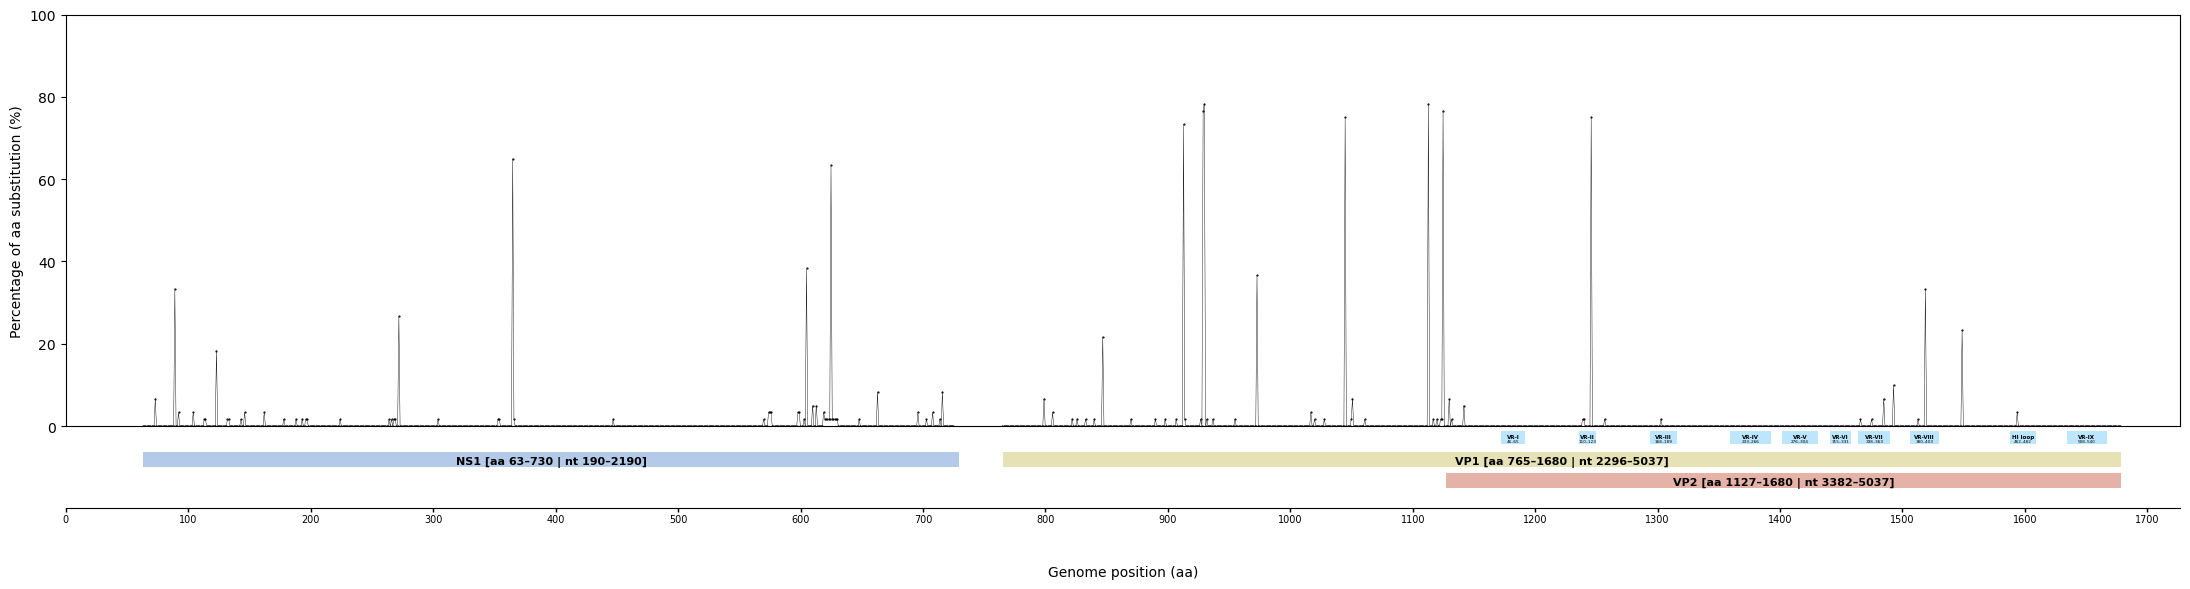

In [17]:
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

###############################################################################
# USER SETTINGS (BIOLOGICALLY CONSISTENT)
###############################################################################

ORF1_FILE = "/home/preonath/Desktop/CHRF_Project/PRV4/PARV4_Analysis_Personal/Analysis_08_12_25/Input_Data/Results/ORF_1_oneline.faa"
ORF2_FILE = "/home/preonath/Desktop/CHRF_Project/PRV4/PARV4_Analysis_Personal/Analysis_08_12_25/Input_Data/Results/ORF_2_oneline.faa"

REFERENCE_SAMPLE = "CSF_0090"

###############################################################################
# TRUE GENOME NT COORDINATES
###############################################################################

NS1_START_NT = 190
NS1_END_NT   = 2190

VP1_START_NT = 2296
VP1_END_NT   = 5037

VP2_START_NT = 3382
VP2_END_NT   = 5037

GENOME_START = 1
GENOME_END   = 5181

###############################################################################
# GENOME NT → GENOME-WIDE AA (NO RESET)
###############################################################################

def genome_nt_to_aa(nt_pos: int) -> int:
    return (nt_pos) // 3


NS1_AA_START = genome_nt_to_aa(NS1_START_NT)
NS1_AA_END   = genome_nt_to_aa(NS1_END_NT) 

VP1_AA_START = genome_nt_to_aa(VP1_START_NT)
VP1_AA_END   = genome_nt_to_aa(VP1_END_NT) + 1

VP2_AA_START = genome_nt_to_aa(VP2_START_NT)
VP2_AA_END   = genome_nt_to_aa(VP2_END_NT) + 1

###############################################################################
# VR REGIONS (VP2 LOCAL AA, 1-BASED)
###############################################################################

VR_REGIONS_AA = [
    ("VR-I",     46,  65),
    ("VR-II",   110, 123),
    ("VR-III",  168, 189),
    ("VR-IV",   233, 266),
    ("VR-V",    276, 304),
    ("VR-VI",   315, 331),
    ("VR-VII",  338, 363),
    ("VR-VIII", 380, 403),
    ("HI loop", 462, 482),
    ("VR-IX",   508, 540),
]

VP2_LEN_AA = (VP2_END_NT - VP2_START_NT + 1) // 3  # will be 535 after END_NT=5037

def iter_vr_regions_clipped():
    for name, a1, a2 in VR_REGIONS_AA:
        if a1 > VP2_LEN_AA:
            continue
        a2_used = min(a2, VP2_LEN_AA)
        yield name, a1, a2_used, (a2_used != a2)

###############################################################################
# VP2 LOCAL AA → GENOME AA
###############################################################################

VP2_GENOME_AA_START = VP2_AA_START  # 1144

def vp2_local_aa_to_genome_aa(a1: int, a2: int):
    g1 = VP2_GENOME_AA_START + (a1 - 1)
    g2 = VP2_GENOME_AA_START + (a2 - 1)
    return g1, g2

###############################################################################
# VP2 LOCAL AA → GENOME NT
###############################################################################

def vp2_aa_range_to_genome_nt(a1: int, a2: int):
    nt_start = VP2_START_NT + (a1 - 1) * 3
    nt_end   = VP2_START_NT + (a2 * 3) - 1
    return nt_start, nt_end

###############################################################################
# SANITY CHECK
###############################################################################

print("NS1 AA:", NS1_AA_START, NS1_AA_END)
print("VP1 AA:", VP1_AA_START, VP1_AA_END)
print("VP2 AA:", VP2_AA_START, VP2_AA_END)

print("\nVR REGIONS (VP2 → GENOME AA)")
for name, a1, a2 in VR_REGIONS_AA:
    g1, g2 = vp2_local_aa_to_genome_aa(a1, a2)
    print(f"{name}: genome-AA {g1}–{g2}")

###############################################################################
# FIND REFERENCE ID
###############################################################################

def find_reference_id(fasta_file, base_id):
    for record in SeqIO.parse(fasta_file, "fasta"):
        if base_id in record.id:
            return record.id
    raise ValueError(f"Reference {base_id} not found in {fasta_file}")

###############################################################################
# CALCULATE MUTATION RATES
###############################################################################

def calculate_mutation_rates(fasta_file, reference_id):

    records = list(SeqIO.parse(fasta_file, "fasta"))

    ref_seq = None
    for r in records:
        if reference_id in r.id:
            ref_seq = str(r.seq)
            break

    if ref_seq is None:
        raise ValueError("Reference sequence not found")

    max_len = len(ref_seq)
    mutation_rates = []

    for pos in range(max_len):
        ref_aa = ref_seq[pos]
        diff = 0
        valid = 0

        for r in records:
            seq = str(r.seq)
            if pos < len(seq):
                valid += 1
                if seq[pos] != ref_aa:
                    diff += 1

        mutation_rates.append((diff / valid * 100) if valid else 0)

    return np.array(mutation_rates)


###############################################################################
# PRINT ALL VR SEQUENCES
###############################################################################

def print_all_vr_sequences_present_code(orf2_fasta, reference_sample):

    for r in SeqIO.parse(orf2_fasta, "fasta"):
        if reference_sample in r.id:
            orf2_seq = str(r.seq)
            break
    else:
        raise ValueError("Reference not found")

    orf2_len = len(orf2_seq)

    vp2_orf2_aa_start = ((VP2_START_NT - VP1_START_NT) // 3) + 1
    if vp2_orf2_aa_start > orf2_len:
        raise ValueError(f"VP2 start ({vp2_orf2_aa_start}) exceeds ORF2 length ({orf2_len}).")

    # VP2 length available in this protein
    vp2_len_data = orf2_len - vp2_orf2_aa_start + 1  # e.g., 535 for your reference

    print("\n" + "=" * 70)
    print(f"ALL VR REGIONS (VP2-based) from reference: {reference_sample}")
    print("=" * 70)

    for name, vp2_a1, vp2_a2 in VR_REGIONS_AA:

        # clip VR end if it exceeds VP2 length in this protein
        vp2_a2_used = min(vp2_a2, vp2_len_data)

        if vp2_a1 > vp2_len_data:
            print(f"\n{name}")
            print("-" * 50)
            print(f"[WARN] {name} starts beyond VP2 length in this data (VP2 len = {vp2_len_data}). Skipping.")
            continue

        orf2_a1 = vp2_orf2_aa_start + vp2_a1 - 1
        orf2_a2 = vp2_orf2_aa_start + vp2_a2_used - 1

        vr_seq = orf2_seq[orf2_a1 - 1 : orf2_a2]

        print(f"\n{name}")
        print("-" * 50)
        if vp2_a2_used != vp2_a2:
            print(f"[WARN] {name} clipped: VP2 end {vp2_a2} → {vp2_a2_used} (VP2 len = {vp2_len_data})")
        print(f"VP2 AA range : {vp2_a1}–{vp2_a2_used}")
        print(f"ORF2 AA range: {orf2_a1}–{orf2_a2}")
        print(f"Length      : {len(vr_seq)} aa")
        print(vr_seq)

    print("=" * 70)


def print_ns1_vp1_vp2_exact_format(orf1_fasta, orf2_fasta, sample_id):

    ns1_seq = None
    orf2_seq = None

    for r in SeqIO.parse(orf1_fasta, "fasta"):
        if sample_id in r.id:
            ns1_seq = str(r.seq)

    for r in SeqIO.parse(orf2_fasta, "fasta"):
        if sample_id in r.id:
            orf2_seq = str(r.seq)

    if ns1_seq is None or orf2_seq is None:
        raise ValueError("Sample not found")

    vp2_orf2_aa_start = ((VP2_START_NT - VP1_START_NT) // 3) + 1

    # expected end from genome coords
    vp2_len_expected = (VP2_END_NT - VP2_START_NT + 1) // 3
    vp2_orf2_aa_end_expected = vp2_orf2_aa_start + vp2_len_expected - 1

    # clamp to real ORF2 protein length
    orf2_len = len(orf2_seq)
    vp2_orf2_aa_end = min(vp2_orf2_aa_end_expected, orf2_len)

    if vp2_orf2_aa_start > orf2_len:
        raise ValueError(f"VP2 start ({vp2_orf2_aa_start}) exceeds ORF2 length ({orf2_len}).")

    vp2_seq = orf2_seq[vp2_orf2_aa_start - 1 : vp2_orf2_aa_end]

    print("\n" + "=" * 70)
    print(f"Sample: {sample_id}")
    print("=" * 70)

    print("\nNS1")
    print("-" * 40)
    print(f"Length : {len(ns1_seq)} aa")
    print(ns1_seq)

    print("\nVP1")
    print("-" * 40)
    print(f"AA range : 1–{orf2_len}")
    print(f"Length  : {orf2_len} aa")
    print(orf2_seq)

    print("\nVP2")
    print("-" * 40)
    if vp2_orf2_aa_end != vp2_orf2_aa_end_expected:
        print(f"[WARN] VP2 end clamped: expected {vp2_orf2_aa_end_expected}, but ORF2 ends at {orf2_len}.")
    print(f"AA range : {vp2_orf2_aa_start}–{vp2_orf2_aa_end}")
    print(f"Length  : {len(vp2_seq)} aa")
    print(vp2_seq)

    print("=" * 70)


###############################################################################
# RUN ALL
###############################################################################

print_all_vr_sequences_present_code(ORF2_FILE, REFERENCE_SAMPLE)

print_ns1_vp1_vp2_exact_format(
    ORF1_FILE,
    ORF2_FILE,
    REFERENCE_SAMPLE
)


# Calculate mutation rates for NS1 and VP1
ns1_ref_id = find_reference_id(ORF1_FILE, REFERENCE_SAMPLE)
vp1_ref_id = find_reference_id(ORF2_FILE, REFERENCE_SAMPLE)

ns1_rates = calculate_mutation_rates(ORF1_FILE, ns1_ref_id)
vp1_rates = calculate_mutation_rates(ORF2_FILE, vp1_ref_id)

from matplotlib.ticker import MultipleLocator

# Colors
NS1_COLOR = "#6996d3"
VP1_COLOR = "#cfc66d"
VP2_COLOR = "#cb6751"
VR_COLOR  = "#bae6fd"


###############################################################################
# HELPERS
###############################################################################


def vp2_aa_range_to_genome_aa(a1, a2):
    """
    VP2 local AA → genome-wide AA coordinates
    """
    g_start = genome_nt_to_aa_number(VP2_START_NT) + (a1 - 1)
    g_end   = genome_nt_to_aa_number(VP2_START_NT) + (a2 - 1)
    return g_start, g_end


def vp2_aa_range_to_genome_nt(a1, a2):
    """
    VP2 local AA → genome NT coordinates
    """
    nt_start = VP2_START_NT + (a1 - 1) * 3
    nt_end   = VP2_START_NT + (a2 * 3) - 1
    return nt_start, nt_end


###############################################################################
# PLOT COMBINED NS1 + VP1 WITH VP2 LABEL (INLINE, NO FUNCTION)
###############################################################################

aa1_genome = NS1_AA_START + np.arange(len(ns1_rates))
aa2_genome = VP1_AA_START + np.arange(len(vp1_rates))

fig, ax = plt.subplots(figsize=(22, 6))

# -----------------------------
# Mutation profiles
# -----------------------------


# Line (background trend)
ax.plot(aa1_genome, ns1_rates, "-", color="black", linewidth=0.3)
ax.plot(aa2_genome, vp1_rates, "-", color="black", linewidth=0.3)

# Dots (foreground signal)
ax.scatter(aa1_genome, ns1_rates, s=.3, color="black", zorder=3)
ax.scatter(aa2_genome, vp1_rates, s=.3, color="black", zorder=3)


# ax.plot(aa1_genome, ns1_rates, "-", color="black", linewidth=0.4)
# ax.plot(aa2_genome, vp1_rates, "-", color="black", linewidth=0.4)


# # Only lines, no dots
# ax.plot(nt1, ns1_rates, "-", color="black", label="NS1", linewidth=.5)
# ax.plot(nt2, vp1_rates, "-", color="black", label="VP1", linewidth=.5)

# # Only dots, no connecting line
# ax.scatter(nt1, ns1_rates, color="black", s=1, label="NS1")   # s = marker size
# ax.scatter(nt2, vp1_rates, color="black", s=1, label="VP1")

# ✅ VP2 LABEL — AXIS-LOCKED (CANNOT DISAPPEAR)
# ax.text(
#     (VP2_AA_START + VP2_AA_END) / 2,
#     0.98,
#     "VP2",
#     transform=ax.get_xaxis_transform(),   # x in data, y in axes
#     ha="center",
#     va="top",
#     fontsize=10,
#     fontweight="bold",
#     color="black"
# )

ax.set_xlim(0, GENOME_END // 3)
ax.set_ylim(0, 100)
ax.set_ylabel("Percentage of aa substitution (%)")

ax.set_xticks([])
ax.tick_params(axis="x", bottom=False, labelbottom=False)
ax.set_xlabel("Genome position (aa)", labelpad=100)

###############################################################################
# ORF ANNOTATION PANEL (NT COORDINATES)
###############################################################################

# One panel containing: NS1/VP1/VP2 + VR rectangles UNDER them
ax_anno = ax.inset_axes([0, -0.16, 1, 0.149])
ax_anno.set_xlim(GENOME_START, GENOME_END)
ax_anno.set_ylim(0, 1)
ax_anno.axis("off")

# keep your original colors
NS1_COLOR = "#6996d3"
VP1_COLOR = "#cfc66d"
VP2_COLOR = "#cb6751"

# NS1 bar (top row)
ax_anno.add_patch(Rectangle((NS1_START_NT, 0.4), NS1_END_NT-NS1_START_NT, 0.25, facecolor=NS1_COLOR, alpha=0.5))
ax_anno.text((NS1_START_NT + NS1_END_NT) / 2, 0.5, f"NS1 [aa {NS1_AA_START}–{NS1_AA_END} | nt {NS1_START_NT}–{NS1_END_NT}]", ha="center", va="center", fontsize=8, fontweight="bold")


# VP1 bar (top row)
ax_anno.add_patch(Rectangle((VP1_START_NT, 0.4), VP1_END_NT-VP1_START_NT, 0.25, facecolor=VP1_COLOR, alpha=0.5))
# ax_anno.text((VP1_START_NT+VP1_END_NT)/2, 0.62, f"VP1 [{VP1_START_NT}–{VP1_END_NT}]", ha="center", va="center", fontsize=10, fontweight="bold")
ax_anno.text((VP1_START_NT + VP1_END_NT) / 2,0.5,f"VP1 [aa {VP1_AA_START}–{VP1_AA_END} | nt {VP1_START_NT}–{VP1_END_NT}]",ha="center", va="center", fontsize=8, fontweight="bold")


# VP2 bar (middle row, exactly like your original)
ax_anno.add_patch(Rectangle((VP2_START_NT, 0.06), VP2_END_NT-VP2_START_NT, 0.25, facecolor=VP2_COLOR, alpha=0.5))
# ax_anno.text((VP2_START_NT+VP2_END_NT)/2, 0.41, f"VP2 [{VP2_START_NT}–{VP2_END_NT}]", ha="center", va="center", fontsize=10, fontweight="bold")
ax_anno.text((VP2_START_NT + VP2_END_NT) / 2,0.16,f"VP2 [aa {VP2_AA_START}–{VP2_AA_END} | nt {VP2_START_NT}–{VP2_END_NT}]",ha="center", va="center", fontsize=8, fontweight="bold")


# VR BLOCKS row (bottom row) — colored regions like NS1/VP1/VP2 (NOT text-only)
VR_COLORS = ["#bae6fd", "#bae6fd", "#bae6fd", "#bae6fd", "#bae6fd", "#bae6fd", "#bae6fd", "#bae6fd", "#bae6fd"]

for i, (name, aa1, aa2) in enumerate(VR_REGIONS_AA):
    nt1, nt2 = vp2_aa_range_to_genome_nt(aa1, aa2)


    # clamp to VP1 region (safety)
    nt1 = max(nt1, VP2_START_NT)
    nt2 = min(nt2, VP2_END_NT)


    if nt2 <= nt1:
        continue
    y = 0.70
    height = 0.18

    # ax_anno.add_patch(Rectangle((nt1, 0.9), nt2 - nt1, .1, facecolor=VR_COLORS[i % len(VR_COLORS)], linewidth=.9, alpha=0.99))
    ax_anno.add_patch(Rectangle((nt1, 0.79), nt2 - nt1, 0.25, facecolor=VR_COLORS[i % len(VR_COLORS)], alpha=0.99))

    ax_anno.text((nt1 + nt2) / 2, 0.9, name, ha="center", va="center", fontsize=4, fontweight="bold")
    
    # Range text (nt1–nt2)
    ax_anno.text((nt1 + nt2) / 2, .9, f"\n\n{aa1}–{aa2}", ha="center", va="center", fontsize=3)

###############################################################################
# GENOME TICKS PANEL (AA numbers only, plotting unchanged)
###############################################################################

###############################################################################
# GENOME TICKS PANEL (AA numbers only, plotting unchanged)
###############################################################################

ax_ticks = ax.inset_axes([0, -0.2, 1, 0.1], transform=ax.transAxes)
ax_ticks.patch.set_alpha(0)

# KEEP genomic coordinate space internally
ax_ticks.set_xlim(GENOME_START, GENOME_END)
ax_ticks.set_ylim(0, 1)

# Tick positions in genome nt (data space)
xticks = np.arange(GENOME_START, GENOME_END + 1, 300)

# Convert labels to AA numbers ONLY
aa_labels = []
for x in xticks:
    aa = genome_nt_to_aa_number(x)
    aa_labels.append("" if aa is None else str(aa))

ax_ticks.set_xticks(xticks)
ax_ticks.set_xticklabels(aa_labels, fontsize=7)

# Y-axis cleanup
ax_ticks.set_yticks([])

# Spine styling (unchanged)
for spine in ["top", "right", "left"]:
    ax_ticks.spines[spine].set_visible(False)
ax_ticks.spines["bottom"].set_visible(True)

ax_ticks.tick_params(axis="x", direction="out", length=3, width=1, pad=1)

###############################################################################
# SAVE
###############################################################################

plt.tight_layout()
plt.savefig("Proportion_of_Non_synonymous_Mutations_of_sct_dot.pdf", dpi=300)




print("\nVR REGIONS (VP2 → GENOME AA)")
for name, a1, a2, clipped in iter_vr_regions_clipped():
    g1, g2 = vp2_local_aa_to_genome_aa(a1, a2)
    msg = f"{name}: genome-AA {g1}–{g2}"
    if clipped:
        msg += f"  [CLIPPED to VP2 len {VP2_LEN_AA}]"
    print(msg)
